In [103]:
import pandas as pd
import os
import sys
from collections import defaultdict
from pathlib import Path
import numpy as np
import json
import ipdb
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
hoops_dir = Path("/Users/danielfriedman/Desktop/hoops")
data_dir = hoops_dir / "data"
sys.path.append(hoops_dir.as_posix())

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 25)

from pipeline import team_metadata, score_by_score

In [250]:
seasons = [f"20{year}-{year+1}" for year in range(17, 22)]


In [251]:
## Get records by date
importlib.reload(team_metadata)
rbd = team_metadata.get_records_by_date(seasons)
rbd.tail()


,date,game_id,home,vis,home_house_wins,home_house_losses,home_road_wins,home_road_losses,vis_house_wins,vis_house_losses,vis_road_wins,vis_road_losses,home_house_games,home_road_games,home_house_win_pct,home_road_win_pct,vis_house_games,vis_road_games,vis_house_win_pct,vis_road_win_pct
5410,2022-02-08,22100818,MEM,LAC,19,9,18,9,16,13,11,15,28,27,0.678571,0.666667,29,26,0.551724,0.423077
5411,2022-02-08,22100819,NOP,HOU,11,13,10,19,8,17,7,21,24,29,0.458333,0.344828,25,28,0.32,0.25
5412,2022-02-08,22100820,DAL,DET,18,10,13,13,8,18,4,23,28,26,0.642857,0.5,26,27,0.307692,0.148148
5413,2022-02-08,22100821,DEN,NYK,14,10,15,14,13,15,11,15,24,29,0.583333,0.517241,28,26,0.464286,0.423077
5414,2022-02-17,22100464,BKN,WAS,12,14,17,11,13,14,11,15,26,28,0.461538,0.607143,27,26,0.481481,0.423077


In [252]:
## Get score by score
importlib.reload(score_by_score)
sbs = score_by_score.get_sbs(seasons)
sbs.tail()

,game_id,home,vis,time,home_score,vis_score,home_win
6,22100629,NOP,LAC,46.38,106,86,True
7,22100629,NOP,LAC,46.65,108,86,True
8,22100629,NOP,LAC,46.75,110,86,True
9,22100629,NOP,LAC,47.28,113,86,True
10,22100629,NOP,LAC,47.40,113,89,True


In [283]:
## Merge!
rbd_ = rbd.copy(deep=True)
rbd_['home_wins'] = rbd_['home_house_wins'] + rbd_['home_road_wins']
rbd_['home_losses'] = rbd_['home_house_losses'] + rbd_['home_road_losses']
rbd_['home_games'] = rbd_['home_wins'] + rbd_['home_losses']
rbd_['home_win_pct'] = rbd_['home_wins'] / (rbd_['home_wins'] + rbd_['home_losses']).replace(0, -1)
rbd_['vis_wins'] = rbd_['vis_house_wins'] + rbd_['vis_road_wins']
rbd_['vis_losses'] = rbd_['vis_house_losses'] + rbd_['vis_road_losses']
rbd_['vis_games'] = rbd_['vis_wins'] + rbd_['vis_losses']
rbd_['vis_win_pct'] = rbd_['vis_wins'] / (rbd_['vis_wins'] + rbd_['vis_losses']).replace(0, -1)
rbd_ = rbd_[['game_id', 'home', 'vis', 'home_win_pct', 'vis_win_pct', 'home_games', 'vis_games']]
m = pd.merge(left=sbs, right=rbd_, on=['game_id', 'home', 'vis'])
m['home_lead'] = m['home_score'] - m['vis_score']
# m['home_win_margin'] = m['home_wins'] - m['home_losses']
# m['vis_win_margin'] = m['vis_wins'] - m['vis_losses']
m = m.loc[(m['home_games'] >= 5) & (m['vis_games'] >=5)]
m.tail()


,game_id,home,vis,time,home_score,vis_score,home_win,mins,home_lead,home_win_pct,vis_win_pct,home_games,vis_games
630473,22100629,NOP,LAC,46.38,106,86,True,46.0,20,0.365854,0.5,41,42
630474,22100629,NOP,LAC,46.65,108,86,True,46.0,22,0.365854,0.5,41,42
630475,22100629,NOP,LAC,46.75,110,86,True,46.0,24,0.365854,0.5,41,42
630476,22100629,NOP,LAC,47.28,113,86,True,47.0,27,0.365854,0.5,41,42
630477,22100629,NOP,LAC,47.40,113,89,True,47.0,24,0.365854,0.5,41,42


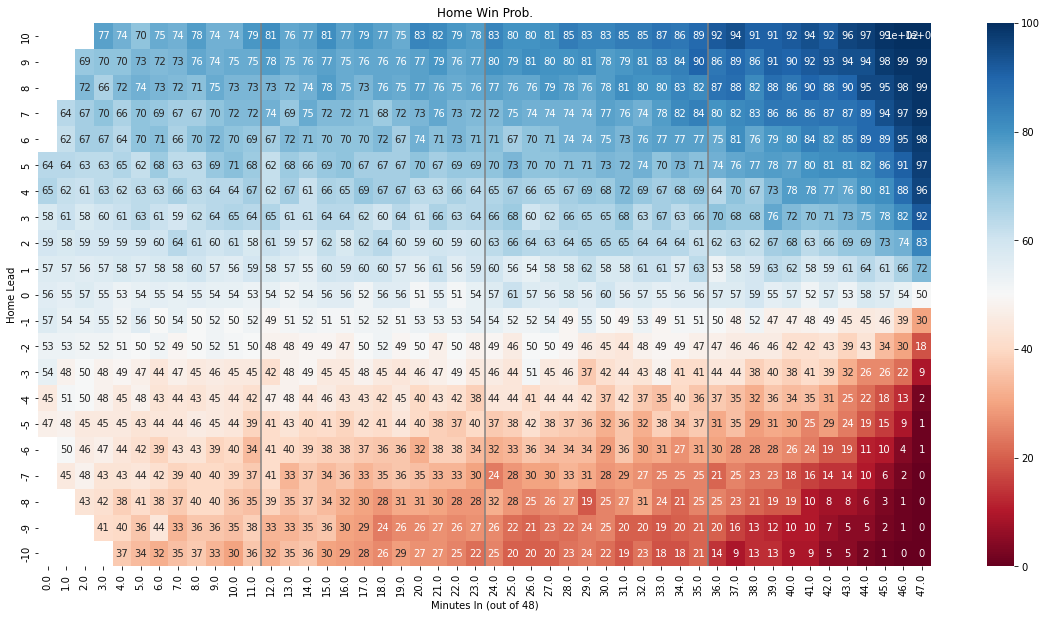

In [284]:
time_mod = 1
score_mod = 1
sbs['mins'] = sbs['time'] // time_mod
sbs['home_lead'] = (sbs['home_score'] - sbs['vis_score']) // score_mod

x = sbs.drop_duplicates(subset=['game_id', 'mins', 'home_lead']).groupby(["mins", "home_lead"]).agg({'home_win': ['count', 'mean']})['home_win'].reset_index().rename(columns={'mean':'win_pct'})
x['win_pct'] = (x['win_pct'] * 100).astype(int)
x = x.loc[x['count'] >= 100]
x = x.pivot(index='home_lead', columns='mins', values='win_pct')
x.index = np.array(list(x.index)) * score_mod
x.columns = np.array(list(x.columns)) * time_mod

fig, ax = plt.subplots(figsize=(20, 10))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
sns.heatmap(x.loc[10:-10:-1, 0:47], annot=True, cmap="RdBu")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Home Win Prob.");



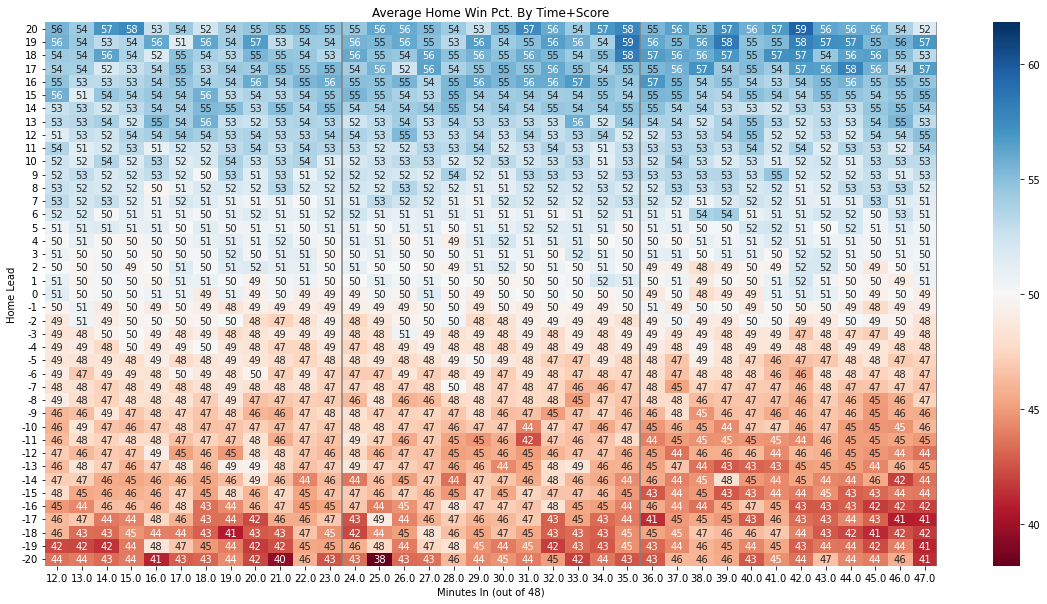

In [297]:
time_mod = 1
score_mod = 1
m['mins'] = m['time'] // time_mod
m['home_lead'] = (m['home_score'] - m['vis_score']) // score_mod

x = m.drop_duplicates(subset=['game_id', 'mins', 'home_lead']).groupby(["mins", "home_lead"])['home_win_pct'].apply(np.mean).reset_index().rename(columns={'home_win_margin':'home_win_margin'})
x = x.pivot(index='home_lead', columns='mins', values='home_win_pct')
x *= 100
x.index = np.array(list(x.index)) * score_mod
x.columns = np.array(list(x.columns)) * time_mod

fig, ax = plt.subplots(figsize=(20, 10))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
x_sub = x.loc[20:-20:-1, 12:47]
max_diff_from_500 = max(x_sub.max().max() - 50, 50-x_sub.min().min())
sns.heatmap(x_sub, annot=True, cmap="RdBu", vmin=50-max_diff_from_500, vmax=50+max_diff_from_500)
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Average Home Win Pct. By Time+Score");



# XGB

In [515]:
from xgboost import XGBClassifier

## Fit
mod = XGBClassifier(
    ## Fitting
    n_estimators=100,
    eta=.1,
    max_depth=4,
    min_child_weight=5,
    
    ## Losses
    objective='binary:logistic',
    eval_metric='logloss',
    
    ## Other
    use_label_encoder=False
)


## Predict
X = m[['home_win_pct', 'vis_win_pct', 'home_lead', 'mins']].to_numpy()
y = m['home_win'].astype(int).to_numpy()
train_size = int(len(X)*.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
mod.fit(X=X_train, y=y_train)
y_hat = mod.predict_proba(X_test)[:,1].round(3)

## Score
mod.score(X_test, y_test)

0.7535418840257467

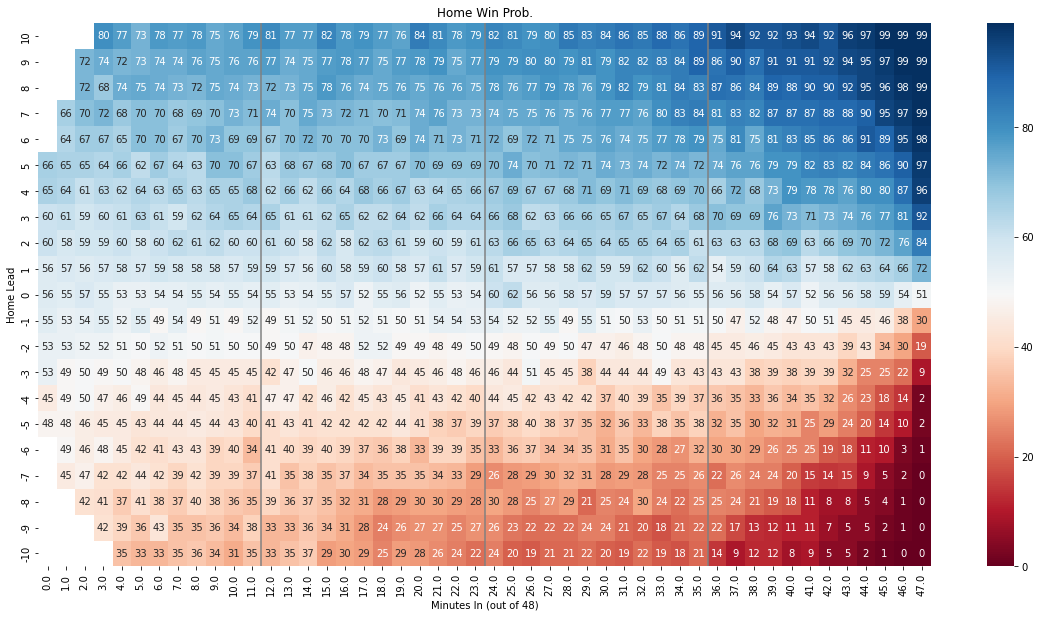

In [516]:
m['yhat'] = yhat
time_mod = 1
score_mod = 1
m['mins'] = m['time'] // time_mod
m['home_lead'] = (m['home_score'] - m['vis_score']) // score_mod

x = m.drop_duplicates(subset=['game_id', 'mins', 'home_lead']).groupby(["mins", "home_lead"]).agg({'yhat': ['count', 'mean']})['yhat'].reset_index().rename(columns={'mean':'yhat'})
x['win_pct'] = (x['yhat'] * 100).astype(int)
x = x.loc[x['count'] >= 100]
x = x.pivot(index='home_lead', columns='mins', values='win_pct')
x.index = np.array(list(x.index)) * score_mod
x.columns = np.array(list(x.columns)) * time_mod

fig, ax = plt.subplots(figsize=(20, 10))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
sns.heatmap(x.loc[10:-10:-1, 0:47], annot=True, cmap="RdBu")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Home Win Prob.");



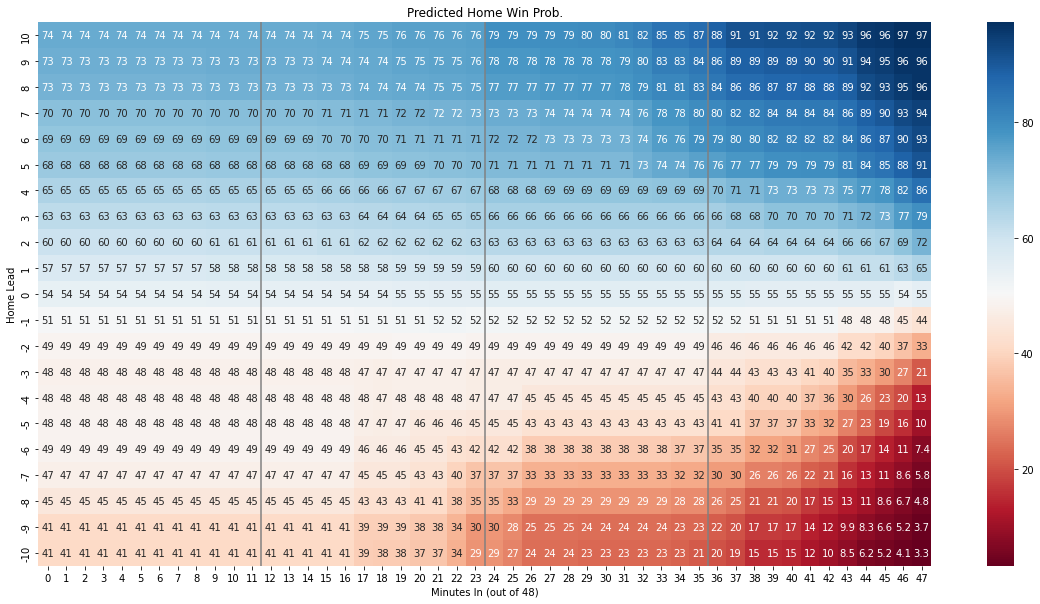

In [517]:
mins = np.arange(0, 48)
home_leads = np.arange(-10, 11)
panel = pd.DataFrame(columns=mins, index=home_leads, dtype=float)
for minute in mins:
    for home_lead in home_leads:
        panel.loc[home_lead, minute] = mod.predict_proba(np.array([[.5, .5, home_lead, minute]]))[0][1]
        
fig, ax = plt.subplots(figsize=(20, 10))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
sns.heatmap(panel[::-1]*100, annot=True, cmap="RdBu")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


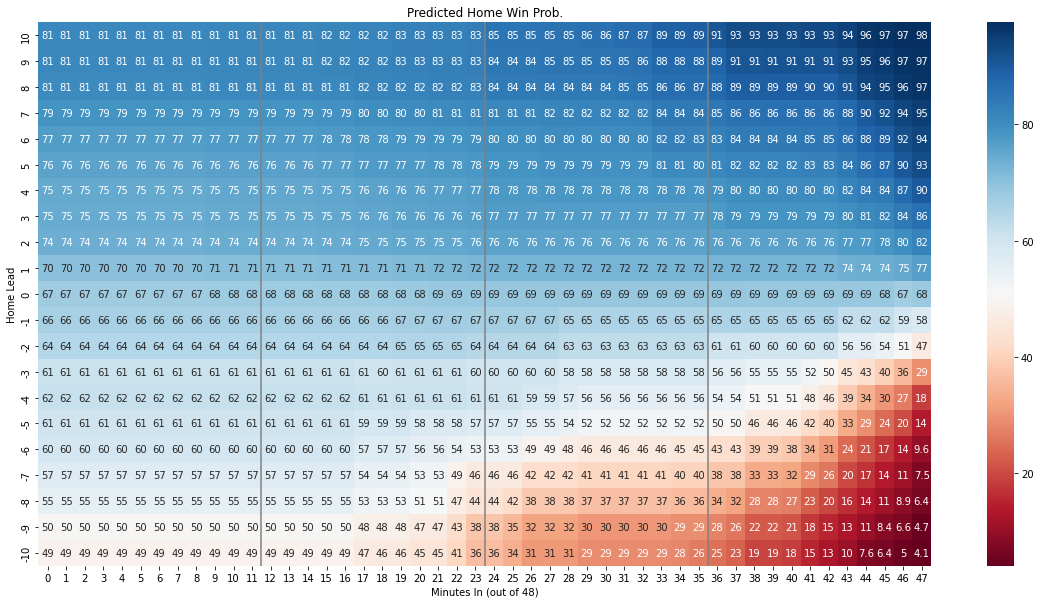

In [518]:
mins = np.arange(0, 48)
home_leads = np.arange(-10, 11)
panel = pd.DataFrame(columns=mins, index=home_leads, dtype=float)
for minute in mins:
    for home_lead in home_leads:
        panel.loc[home_lead, minute] = mod.predict_proba(np.array([[.65, .5, home_lead, minute]]))[0][1]
        
fig, ax = plt.subplots(figsize=(20, 10))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
sns.heatmap(panel[::-1]*100, annot=True, cmap="RdBu")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


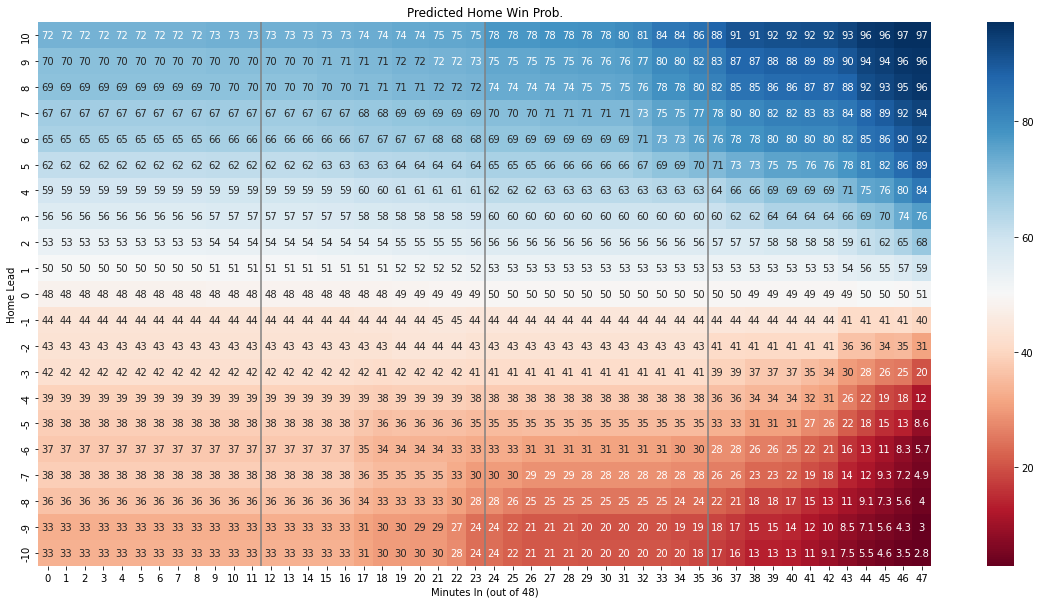

In [519]:
mins = np.arange(0, 48)
home_leads = np.arange(-10, 11)
panel = pd.DataFrame(columns=mins, index=home_leads, dtype=float)
for minute in mins:
    for home_lead in home_leads:
        panel.loc[home_lead, minute] = mod.predict_proba(np.array([[.5, .65, home_lead, minute]]))[0][1]
        
fig, ax = plt.subplots(figsize=(20, 10))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
sns.heatmap(panel[::-1]*100, annot=True, cmap="RdBu")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");
